# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Coupled soil root hydraulics 


In [1]:
import os
#sourcedir = os.getcwd()+"/../../../"
sourcedir = "/opt/dumux/CPlantBox/"
import sys;  
sys.path.append(sourcedir+"../dumux-rosi/python/modules");
sys.path.append(sourcedir+"../dumux-rosi/build-cmake/cpp/python_binding/");
sys.path.append(sourcedir)  
sys.path.append(sourcedir+"src") 

import plantbox as pb
import visualisation.vtk_plot as vp
from functional.PlantHydraulicParameters import PlantHydraulicParameters
from functional.PlantHydraulicModel import HydraulicModel_Doussan
from functional.PlantHydraulicModel import HydraulicModel_Meunier
from functional.Perirhizal import PerirhizalPython as Perirhizal
import functional.van_genuchten as vg

from rosi_richards import RichardsSP  # C++ part (Dumux binding)
from richards import RichardsWrapper  # Python part
import numpy as np
import matplotlib.pyplot as plt
import figure_style
import timeit

def sinusoidal(t):
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.


def make_source(q, area):
    s = {}
    for i in range(0, len(q)):
        if not np.isnan(q[i]):
            s[i] = -q[i] * area

    return s

## Full root system model with a simplified soil:

No parameter file found. Continuing without parameter file.
Computed bounding box tree with 49 nodes for 25 grid entities in 1.8597e-05 seconds.
Computed bounding box tree with 49 nodes for 25 grid entities in 1.7497e-05 seconds.
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Shoot borne definition is DEPRICATED, shoot borne roots will be handeled like basal roots 
Organism::simulate: from 0 to 10 days
nodes moved 0
new nodes added 2428
segments added 2428
Number of segments 2429, including 2428 new 
 -- Using the default temperature of 293.15 in the entire domain. Overload temperatureAtPos() in your spatial params class to define a custom temperature field.Or provide the preferred domain temperature via the SpatialParams.Temperature parameter.
[                                                                                                    ], [-659.3, -635.3] cm soil [-659.843, -641.28] cm root at 0.00416667 days -659.843
[*****                          

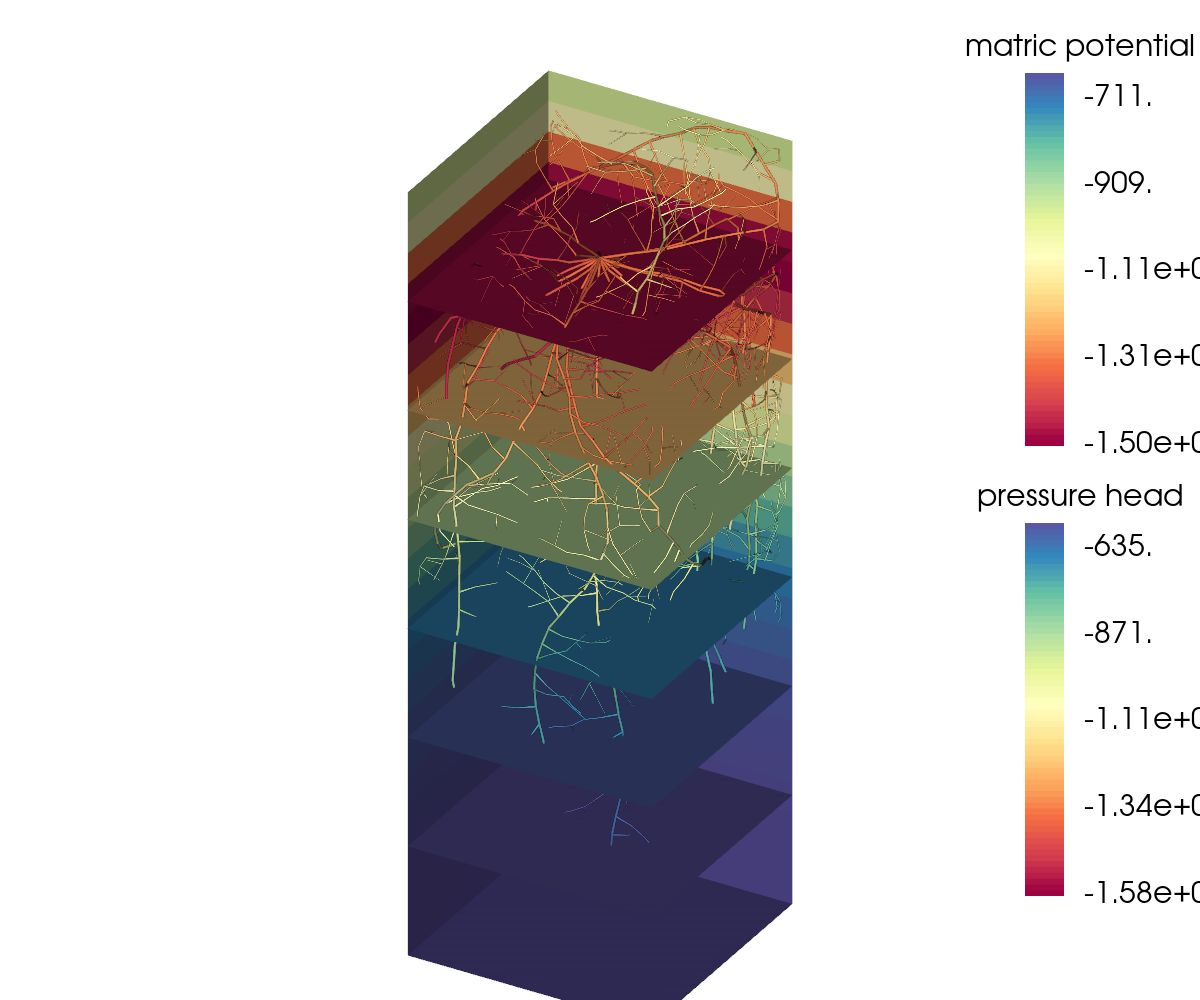

2025-09-08 21:40:41.025 (  17.267s) [    7E0A72103080]       vtkXMLWriter.cxx:636    ERR| vtkXMLPolyDataWriter (0x432adf30): Error opening output file "results/Zeamays_synMRI_modified.vtp"
2025-09-08 21:40:41.025 (  17.267s) [    7E0A72103080]       vtkXMLWriter.cxx:638    ERR| vtkXMLPolyDataWriter (0x432adf30): Error code "No such file or directory"
2025-09-08 21:40:41.025 (  17.267s) [    7E0A72103080]       vtkExecutive.cxx:729    ERR| vtkCompositeDataPipeline (0x422073c0): Algorithm vtkXMLPolyDataWriter (0x432adf30) returned failure for request: vtkInformation (0x434c25a0)
  Debug: Off
  Modified Time: 104369
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-09-08 21:40:41.026 (  17.268s) [    7E0A72103080]       vtkXMLWriter.cxx:636    ERR| vtkXMLImageDataWriter (0x4339dda0): Error opening output file "results/Zeamays_synMRI_modified.vtu"
2025-09-08 21:40:41.026 (  17.268s) [  

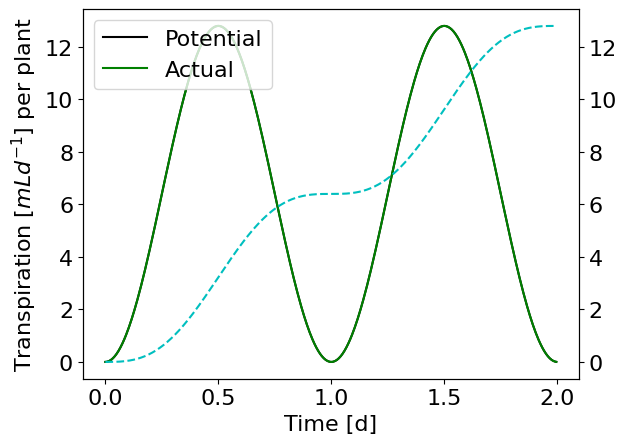

In [2]:

path = sourcedir +"modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI_modified" 
loam = [0.08, 0.43, 0.04, 1.6, 50]
initial = -659.8 + 12.5  # -659.8

trans = 6.4  # cm3 /day (sinusoidal)
wilting_point = -15000  # cm

sim_time = 2  # [day] 
rs_age = 10  # root system initial age
age_dependent = False  # conductivities
dt = 360. / (24 * 3600)  # [days] Time step must be very small

def run_simulation(min_b, max_b, cell_number):        
    """ Initialize macroscopic soil model """
    s = RichardsWrapper(RichardsSP())
    s.initialize()
    periodic = False
    s.createGrid(min_b, max_b, cell_number, periodic)  # [cm]
    s.setHomogeneousIC(initial, True)  # cm pressure head, equilibrium
    s.setTopBC("noFlux")
    s.setBotBC("noFlux")
    s.setVGParameters([loam])
    s.setParameter("Soil.SourceSlope", "1000")
    s.initializeProblem()
    s.setCriticalPressure(wilting_point)
    
    """ Initialize xylem model """
    plant = pb.MappedPlant()
    plant.enableExtraNode()
    plant.readParameters(path + name + ".xml")
    if not periodic:
        sdf = pb.SDF_PlantBox(0.95 * (max_b[0] - min_b[0]), 0.95 * (max_b[1] - min_b[1]), max_b[2] - min_b[2])
    else:
        sdf = pb.SDF_PlantBox(np.inf, np.inf, max_b[2] - min_b[2])
    plant.setGeometry(sdf)
    
    """ root hydraulic properties """
    params = PlantHydraulicParameters()  
    params.read_parameters(sourcedir +"modelparameter/functional/plant_hydraulics/couvreur2012")
    hm = HydraulicModel_Doussan(plant, params)  
    # hm = HydraulicModel_Meunier(plant, params)
    hm.wilting_point = wilting_point
    
    """ Coupling (map indices) """
    picker = lambda x, y, z: s.pick([x, y, z]) 
    plant.setSoilGrid(picker)  # maps segments
    plant.initialize(True)
    plant.simulate(rs_age, True)
    
    """ Numerical solution """
    start_time = timeit.default_timer()
    x_, y_ = [], []
    N = round(sim_time / dt)
    t = 0.
    
    for i in range(0, N):
    
        plant.simulate(dt)
        hs = s.getSolutionHead()
        hx = hm.solve(rs_age+t, -trans*sinusoidal(t), hs, cells=True)
        
        water = s.getWaterVolume()
        fluxes = hm.soil_fluxes(rs_age+t,hx,hs)
        s.setSource(fluxes)
        s.solve(dt)
        soil_water = (s.getWaterVolume() - water) / dt
        
        x_.append(t)
        y_.append(float(hm.get_transpiration(rs_age + t, hx, hs, cells=True)))  # exact root collar flux
        
        if i % 25 == 0:
            n = round(float(i) / float(N) * 100.)
            print("[" + ''.join(["*"]) * n + ''.join([" "]) * (100 - n) + "], [{:g}, {:g}] cm soil [{:g}, {:g}] cm root at {:g} days {:g}"
                    .format(np.min(hs), np.max(hs), np.min(hx), np.max(hx), s.simTime, hx[0]))    
    
        t += dt
    
    print ("Coupled problem solved in ", timeit.default_timer() - start_time, " s")
    """ VTK visualisation """
    vp.plot_roots_and_soil(hm.ms.mappedSegments(), "matric potential", hx, s, True, 
                           np.array(min_b), np.array(max_b), cell_number, name, 
                           interactiveImage = False)
    
    """ transpiration over time """
    fig, ax1 = plt.subplots()
    ax1.plot(x_, trans * sinusoidal(x_), 'k')  # potential transpiration
    ax1.plot(x_, -np.array(y_), 'g')  # actual transpiration (neumann)
    ax2 = ax1.twinx()
    ax2.plot(x_, np.cumsum(-np.array(y_) * dt), 'c--')  # cumulative transpiration (neumann)
    ax1.set_xlabel("Time [d]")
    ax1.set_ylabel("Transpiration $[mL d^{-1}]$ per plant")
    ax1.legend(['Potential', 'Actual', 'Cumulative'], loc = 'upper left')
    np.savetxt(name, np.vstack((x_, -np.array(y_))), delimiter = ';')
    plt.show()
    return s, plant, hm

min_b = [-4., -4., -25.]
max_b = [4., 4., 0.]
cell_number = [1, 1, 25] 
s, plant, hm = run_simulation(min_b, max_b, cell_number)

## Simplified root system model with a simplified soil:

In [14]:
path = sourcedir +"modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI_modified" 
loam = [0.08, 0.43, 0.04, 1.6, 50]
initial = 4 * (-659.8 + 12.5 ) # -659.8
trans = 1.5 * 400  # cm3 /day (sinusoidal) = mL/day 
wilting_point = -15000  # cm

sim_time = 2  # [day] 
rs_age = 55  # root system initial age
age_dependent = False  # conductivities
dt = 360. / (24 * 3600)  # [days] Time step must be very small

min_b = [-8., -36., -100.]
max_b = [8., 36., 0.]
cell_number = [1, 1, 50] 
""" Initialize macroscopic soil model """
s = RichardsWrapper(RichardsSP())
s.initialize()
periodic = True
s.createGrid(min_b, max_b, cell_number, periodic)  # [cm]
s.setHomogeneousIC(initial, True)  # cm pressure head, equilibrium
s.setTopBC("noFlux")
s.setBotBC("noFlux")
s.setVGParameters([loam])
s.setParameter("Soil.SourceSlope", "1000")
s.initializeProblem()
s.setCriticalPressure(wilting_point)

sp = vg.Parameters(loam)  # needed for Perirhizal class
vg.create_mfp_lookup(sp, wilting_point = -16000, n = 1501)

""" Initialize xylem model """
plant = pb.MappedPlant() 
plant.enableExtraNode()
plant.readParameters(path + name + ".xml")
sdf = pb.SDF_PlantBox(np.inf, np.inf, max_b[2] - min_b[2] - 0.5)  
plant.setGeometry(sdf)  
plant.setRectangularGrid(pb.Vector3d(min_b), pb.Vector3d(max_b), pb.Vector3d(cell_number), False, False)  # needed for Perirhizal class


""" root hydraulic properties """
params = PlantHydraulicParameters()  
params.read_parameters(sourcedir +"modelparameter/functional/plant_hydraulics/couvreur2012")
hm = HydraulicModel_Doussan(plant, params)  
# hm = HydraulicModel_Meunier(plant, params)
hm.wilting_point = wilting_point

""" Coupling (map indices) """
picker = lambda x, y, z: s.pick([0, 0, z]) 
plant.setSoilGrid(picker)  # maps segments
plant.initialize(True)
plant.simulate(rs_age, True)

""" Numerical solution """
start_time = timeit.default_timer()
x_, y_ = [], []
N = round(sim_time / dt)
t = 0.

hm.test()
peri = Perirhizal(plant)

No parameter file found. Continuing without parameter file.
Computed bounding box tree with 99 nodes for 50 grid entities in 2.34e-05 seconds.
Computed bounding box tree with 99 nodes for 50 grid entities in 1.39e-05 seconds.
initializing look up tables
done
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Shoot borne definition is DEPRICATED, shoot borne roots will be handeled like basal roots 
Organism::simulate: from 0 to 55 days
nodes moved 0
new nodes added 46802
segments added 46802
Number of segments 46803, including 46802 new 
PlantHydraulicModel.test():
46804 nodes:
Node 0 [ 0.1  0.  -3. ]
Node 1 [ 0.  0. -3.]
Node 2 [ 0.10002505  0.15035658 -3.46624874]
Node 3 [ 0.19704992  0.30521856 -3.93165603]
Node 4 [ 0.27189578  0.40373656 -4.28739468]
46803 segments:
Segment 0 [0 1] subType 0
Segment 1 [1 2] subType 1
Segment 2 [2 3] subType 1
Segment 3 [3 4] subType 1
Segment 4 [4 5] subType 2
Collar segment index 0
Collar segment [0 1]
0 segments with length

In [15]:

area = (plant.maxBound.x - plant.minBound.x) * (plant.maxBound.y - plant.minBound.y)  # [cm2]
h_eff_, t_pot_p_, t_act_p_, t_act_s_ = [], [], [], []

for i in range(0, N): 

    h_bs = s.getSolutionHead()
    h_bs = np.array(plant.matric2total(h_bs))

    start_time_ao = timeit.default_timer()

    hm.update(rs_age + sim_time)


    suf_ = hm.suf
    suf = peri.aggregate(suf_[0,:])

    h_eff = sum(suf * h_bs)
    t_pot = trans * sinusoidal(t) / area  # potential tranpiration [cm3 day-1] -> [cm day-1]

    t_act = min(hm.krs/area* (h_eff - wilting_point), t_pot)
    q = suf * t_act
    
    start_time_soil = timeit.default_timer()

    fluxes = make_source(q, area)
    water = s.getWaterVolume()
    s.setSource(fluxes)
    s.solve(dt) 
    d_water_dt = (water - s.getWaterVolume())/dt
    final_time = timeit.default_timer()
    
    h_eff_.append(h_eff) 
    t_pot_p_.append(t_pot * area)
    t_act_p_.append(t_act * area)
    t_act_s_.append(d_water_dt)
    x_.append(t)
    y_.append(d_water_dt) 
    if i%10 == 0:
        n = round(float(i) / float(N) * 100.)  
        print("[" + ''.join(["*"]) * n + ''.join([" "]) * (100 - n) + "], potential plant {:g}, actual plant {:g}, actual soil {:g}; {:g} cm H_eff [{:g}, {:g}] cm soil at {:g} days"
                .format(t_pot * area, t_act * area, d_water_dt, h_eff, np.min(h_bs), np.max(h_bs), s.simTime))
    t += dt  # [day]

[                                                                                                    ], potential plant 0, actual plant 0, actual soil 0; -2609.91 cm H_eff [-2645.38, -2543.2] cm soil at 0.00416667 days
[**                                                                                                  ], potential plant 20.4445, actual plant 20.4445, actual soil 20.4445; -2610.52 cm H_eff [-2645.39, -2543.2] cm soil at 0.0458333 days
[****                                                                                                ], potential plant 80.3848, actual plant 80.3848, actual soil 80.3848; -2615.14 cm H_eff [-2651.63, -2543.2] cm soil at 0.0875 days
[******                                                                                              ], potential plant 175.736, actual plant 175.736, actual soil 175.736; -2627.81 cm H_eff [-2676.9, -2543.2] cm soil at 0.129167 days
[********                                                                     

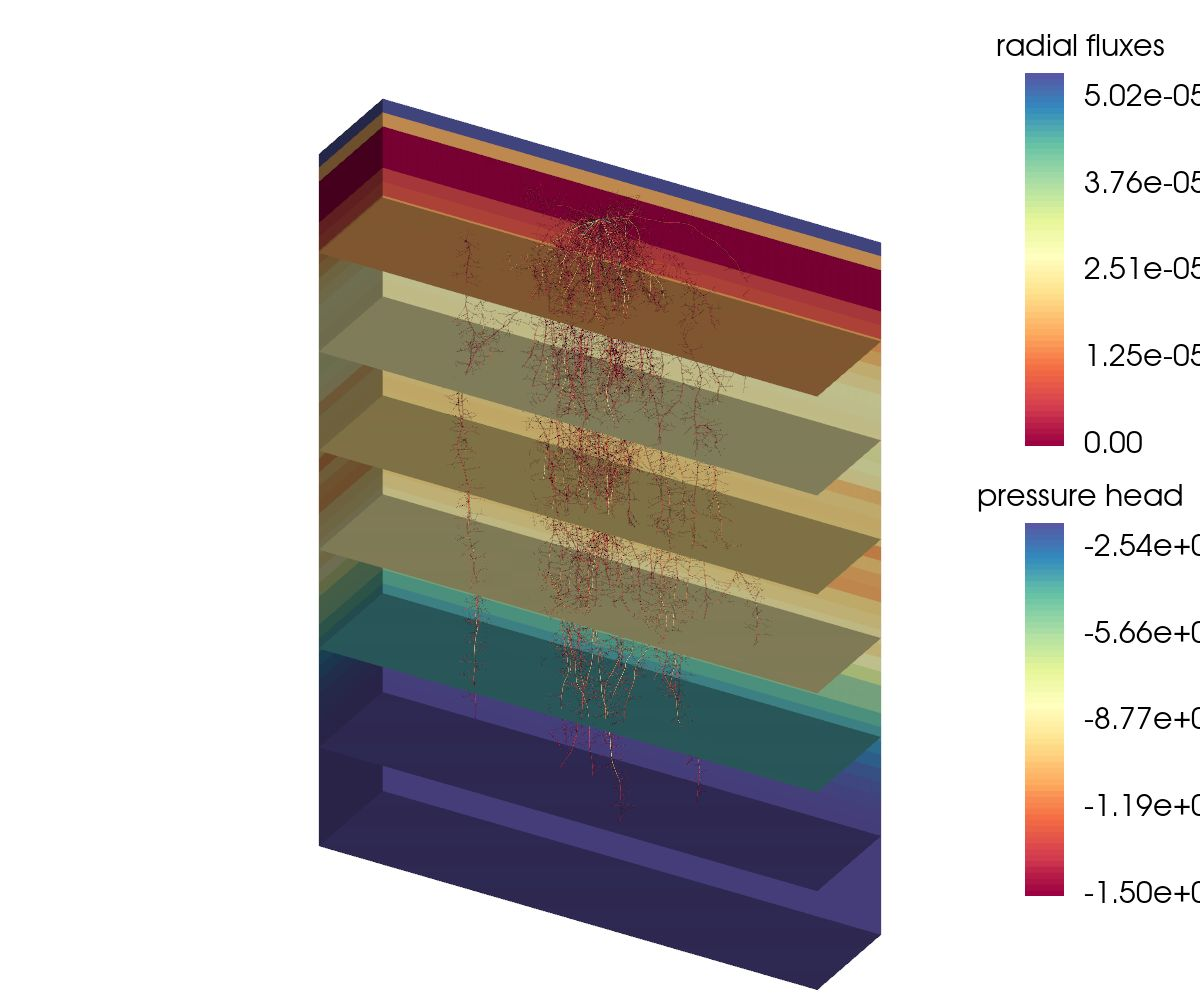

2025-09-08 21:50:37.498 ( 613.740s) [    7E0A72103080]       vtkXMLWriter.cxx:636    ERR| vtkXMLPolyDataWriter (0x4387c560): Error opening output file "results/Zeamays_synMRI_modified.vtp"
2025-09-08 21:50:37.498 ( 613.741s) [    7E0A72103080]       vtkXMLWriter.cxx:638    ERR| vtkXMLPolyDataWriter (0x4387c560): Error code "No such file or directory"
2025-09-08 21:50:37.498 ( 613.741s) [    7E0A72103080]       vtkExecutive.cxx:729    ERR| vtkCompositeDataPipeline (0x560bdb80): Algorithm vtkXMLPolyDataWriter (0x4387c560) returned failure for request: vtkInformation (0x3eb7f940)
  Debug: Off
  Modified Time: 3187934
  Reference Count: 1
  Registered Events: (none)
  Request: REQUEST_DATA
  FROM_OUTPUT_PORT: -1
  ALGORITHM_AFTER_FORWARD: 1
  FORWARD_DIRECTION: 0


2025-09-08 21:50:37.499 ( 613.741s) [    7E0A72103080]       vtkXMLWriter.cxx:636    ERR| vtkXMLImageDataWriter (0x502d8710): Error opening output file "results/Zeamays_synMRI_modified.vtu"
2025-09-08 21:50:37.499 ( 613.741s) [ 

In [16]:

vp.plot_roots_and_soil(hm.ms.mappedSegments(),
                       "radial fluxes", hm.get_suf(rs_age) * d_water_dt, s, True, 
                       np.array(min_b), np.array(max_b), cell_number, name,
                       interactiveImage = False)

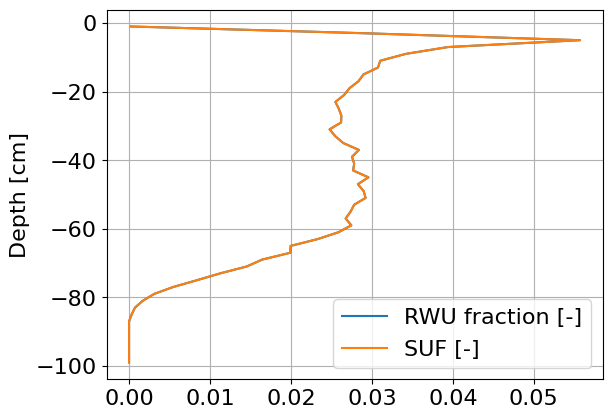

In [17]:
depth_array = [cc[2] for cc in s.getCellCenters()]
plt.plot(q/sum(q), depth_array, label = "RWU fraction [-]")
plt.plot(suf, depth_array, label = "SUF [-]")
plt.ylabel("Depth [cm]")
plt.grid(True)
plt.legend()
plt.show()  

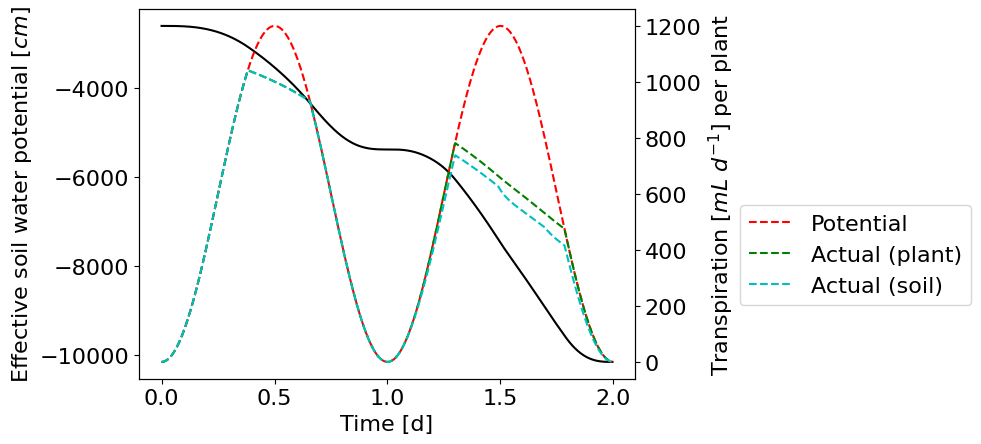

In [26]:

fig, ax1 = plt.subplots()
ax1.plot(x_, h_eff_, 'k')  
ax2 = ax1.twinx()
ax2.plot(x_, np.array(t_pot_p_), 'r--', label = "Potential") 
ax2.plot(x_, np.array(t_act_p_), 'g--', label = "Actual (plant)")
ax2.plot(x_, np.array(y_), 'c--', label = "Actual (soil)") 
ax1.set_xlabel("Time [d]")
ax1.set_ylabel("Effective soil water potential $[cm]$")
ax2.set_ylabel("Transpiration $[mL~d^{-1}]$ per plant")
plt.legend(bbox_to_anchor=(1.7, 0.5))
plt.show()

## The alpha and omega of RWU (Vanderborght et al. 2024)

In [8]:
""" Parameters """  
verbose = False
depth = -100
N = 100
min_b = [-10., -10., depth]  # [cm]
max_b = [10., 10., 0.]  # [cm]
cell_number = [1, 1, N]  # [cm3]

kx = 10 * 4.32e-2  # axial conductivity [cm3/day]
kr = 1.728e-4  # radial conductivity [1/day]

path = sourcedir + "modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI_modified"  #"Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010, Zeamays_synMRI.xml  <<<<-------
trans = 1.5 * 400  # cm3 /day (sinusoidal) = mL/day
wilting_point = -15000  # cm
rs_age = 60  # root system initial age [day]

loam = [0.01, 0.43, 0.0083, 1.2539, 2.272]  # jan paper
sp = vg.Parameters(loam)  # needed for Perirhizal class
vg.create_mfp_lookup(sp, wilting_point = -16000, n = 1501)  # needed for Perirhizal class
initial = -500  # cm (-330 )

sim_time = 7  # [day]
dt = 3600. / (24 * 3600)  # [days]  # |\label{l7xa:param_end}|


initializing look up tables
done


In [9]:

""" Initialize macroscopic soil model """
s = RichardsWrapper(RichardsSP())  
s.initialize()
s.createGrid(min_b, max_b, cell_number, periodic = True)  # [cm]
s.setHomogeneousIC(initial, False)  # [cm] False = matrix, True, = total potential
s.setTopBC("noFlux")
s.setBotBC("noFlux")
s.setVGParameters([loam])
s.setParameter("Soil.SourceSlope", "100") 
s.initializeProblem()
s.setCriticalPressure(wilting_point)  

""" Initialize xylem model """
plant = pb.MappedPlant() 
plant.enableExtraNode()
plant.readParameters(path + name + ".xml")
sdf = pb.SDF_PlantBox(np.inf, np.inf, max_b[2] - min_b[2] - 0.5)  
plant.setGeometry(sdf)  
plant.setRectangularGrid(pb.Vector3d(min_b), pb.Vector3d(max_b), pb.Vector3d(cell_number), False, False)  # needed for Perirhizal class

""" root hydraulic properties """
params = PlantHydraulicParameters()  
params.read_parameters(sourcedir + "modelparameter/functional/plant_hydraulics/couvreur2012")
# params.set_kr_const(kr)
# params.set_kx_const(kx)
# params.plot_conductivities(True) 
hm = HydraulicModel_Doussan(plant, params)
hm.wilting_point = wilting_point  

""" Coupling (map indices) """
picker = lambda x, y, z: s.pick([0, 0, z]) 
plant.setSoilGrid(picker)
plant.initialize(True)
plant.simulate(rs_age, True)
hm.test() 

peri = Perirhizal(plant)
h_bs = s.getSolutionHead()
h_sr = np.ones(h_bs.shape) * wilting_point


No parameter file found. Continuing without parameter file.
Computed bounding box tree with 199 nodes for 100 grid entities in 2.03e-05 seconds.
Computed bounding box tree with 199 nodes for 100 grid entities in 1.72e-05 seconds.
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Shoot borne definition is DEPRICATED, shoot borne roots will be handeled like basal roots 
Organism::simulate: from 0 to 60 days
nodes moved 0
new nodes added 54110
segments added 54110
Number of segments 54111, including 54110 new 
PlantHydraulicModel.test():
54112 nodes:
Node 0 [ 0.1  0.  -3. ]
Node 1 [ 0.  0. -3.]
Node 2 [ 0.07541065 -0.03081434 -3.49331908]
Node 3 [ 0.15876751 -0.05878518 -3.98552764]
Node 4 [ 0.23710489 -0.07185231 -4.35369906]
54111 segments:
Segment 0 [0 1] subType 0
Segment 1 [1 2] subType 1
Segment 2 [2 3] subType 1
Segment 3 [3 4] subType 1
Segment 4 [4 5] subType 2
Collar segment index 0
Collar segment [0 1]
0 segments with length < 1.e-5 cm
6 different root 

In [10]:
""" Numerical solution """
start_time = timeit.default_timer()
t = 0.
x_, y_ = [], []
N = round(sim_time / dt)
area = (plant.maxBound.x - plant.minBound.x) * (plant.maxBound.y - plant.minBound.y)  # [cm2]
verbose = False
for i in range(0, N): 

    h_bs = s.getSolutionHead()
    h_bs = np.array(plant.matric2total(h_bs))

    start_time_ao = timeit.default_timer()

    hm.update(rs_age + sim_time)

    # Alpha: root system averaged stress factor
    # krs, _ = hm.get_krs(rs_age + sim_time)  # [cm2/day] (could be precomputed for static case)
    krs = hm.krs
    krs = krs / area
    if verbose:
        print("krs", krs)

    k_srs = hm.get_soil_rootsystem_conductance(rs_age + sim_time, h_bs, wilting_point, sp)
    h_bs_diff = h_bs - np.ones(h_bs.shape) * wilting_point
    alpha = np.multiply(k_srs, h_bs_diff) / (-krs * wilting_point)  # [1]

    # Omega: root system averaged stress factor
    # suf_ = hm.get_suf(rs_age + sim_time)
    suf_ = hm.suf
    suf = peri.aggregate(suf_[0,:])
    alphaSUF = np.multiply(alpha, suf)
    omega = np.nansum(alphaSUF)  # note that nan are treated as 0
    if verbose:
        print("omega", omega)

    # Omega_c: critical stress factor
    tp = trans * sinusoidal(t) / area  # potential tranpiration [cm3 day-1] -> [cm day-1]
    # print("tp", tp)
    omega_c = tp / (-wilting_point * krs)
    if verbose:
        print("max uptake", (-wilting_point * krs), tp)
        print("omega_c", omega_c)
        print("omega / omega_c", omega / omega_c)

    # Sink, stressed
    q_s = alphaSUF * tp / omega_c

    # Sink, unstressed
    denumerator = np.multiply(h_bs_diff, np.nansum(np.divide(alphaSUF, h_bs_diff)))
    if verbose:
        print("denumerator", np.nansum(denumerator), np.nanmin(denumerator), np.nanmax(denumerator))
        print("- term: ", np.nansum(np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp))
    q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp

    if verbose:
        print("pot", tp, "q_us", np.nansum(q_us), "q_s", np.nansum(q_s))

    if omega < omega_c:
        print("stressed")
        q = q_s
    else:
        print("unstressed")
        q = q_us

    start_time_soil = timeit.default_timer()

    fluxes = make_source(q, area)
    s.setSource(fluxes)
    s.solve(dt) 

    final_time = timeit.default_timer()

    x_.append(t)
    y_.append(-np.nansum(q) * area) 

    n = round(float(i) / float(N) * 100.)  
    print("[" + ''.join(["*"]) * n + ''.join([" "]) * (100 - n) + "], potential {:g}, actual {:g}; [{:g}, {:g}] cm soil at {:g} days"
            .format(tp * area, np.nansum(q) * area, np.min(h_bs), np.max(h_bs), s.simTime))

    print("wall times:", (start_time_ao - start_time_soil) / (start_time_ao - final_time), (start_time_soil - final_time) / (start_time_ao - final_time))

    t += dt  # [day]

print ("Coupled benchmark solved in ", timeit.default_timer() - start_time, " s")  # |\label{l7xa:timing}|


/home/rbtl2404/dumuxDaniel/dumux/CPlantBox/tutorial/jupyter/summer_school_2025/../../../src/functional/Perirhizal.py:105: RuntimeWarning: divide by zero encountered in divide
  r_phriz = np.divide(1., np.sqrt(np.pi * rld))  # outer perirhizal radii per layer [cm]
/home/rbtl2404/dumuxDaniel/dumux/CPlantBox/tutorial/jupyter/summer_school_2025/../../../src/functional/Perirhizal.py:108: RuntimeWarning: invalid value encountered in add
  b = np.divide(2 * (rho2 - np.ones(rho2.shape)) , np.ones(rho2.shape) - 0.53 * 0.53 * rho2 + 2 * rho2 * (np.log(rho) + np.log(0.53)))  # [1], see Eqn [8]
/tmp/ipykernel_606/2678138449.py:47: RuntimeWarning: invalid value encountered in divide
  q_s = alphaSUF * tp / omega_c
/tmp/ipykernel_606/2678138449.py:54: RuntimeWarning: invalid value encountered in divide
  q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp
/tmp/ipykernel_606/2678138449.py:54: RuntimeWarning: divide by zero encountered in scalar divide
  q_us

unstressed
[                                                                                                    ], potential 0, actual 0; [-510.01, -503] cm soil at 0.0416667 days
wall times: 0.990195856205337 0.00980414379466302
unstressed
[*                                                                                                   ], potential 20.4445, actual 20.4445; [-510.01, -502.545] cm soil at 0.0833333 days
wall times: 0.9883943083393906 0.011605691660609454
unstressed
[*                                                                                                   ], potential 80.3848, actual 80.3848; [-510.397, -502.212] cm soil at 0.125 days
wall times: 0.9923529145359282 0.007647085464071753
unstressed
[**                                                                                                  ], potential 175.736, actual 175.736; [-512.105, -501.949] cm soil at 0.166667 days
wall times: 0.9931036205593228 0.006896379440677184
unstressed
[**               

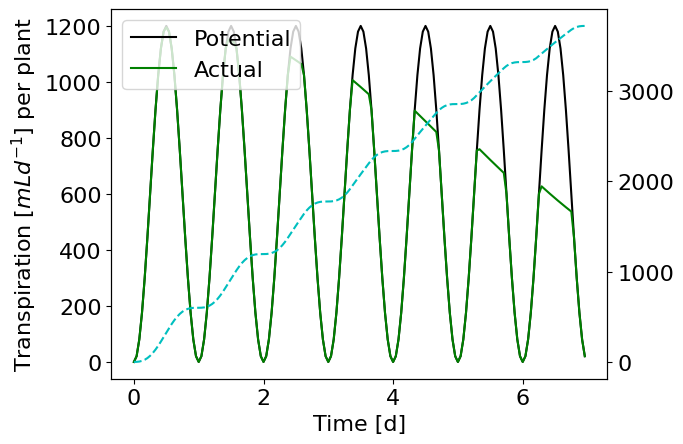

In [11]:
""" Transpiration over time """
fig, ax1 = plt.subplots()
ax1.plot(x_, trans * sinusoidal(x_), 'k')  # potential transpiration
ax1.plot(x_, -np.array(y_), 'g')  # actual transpiration
ax2 = ax1.twinx()
ax2.plot(x_, np.cumsum(-np.array(y_) * dt), 'c--')  # cumulative transpiratio
ax1.set_xlabel("Time [d]")
ax1.set_ylabel("Transpiration $[mL d^{-1}]$ per plant")
ax1.legend(['Potential', 'Actual', 'Cumulative'], loc = 'upper left')
plt.show()

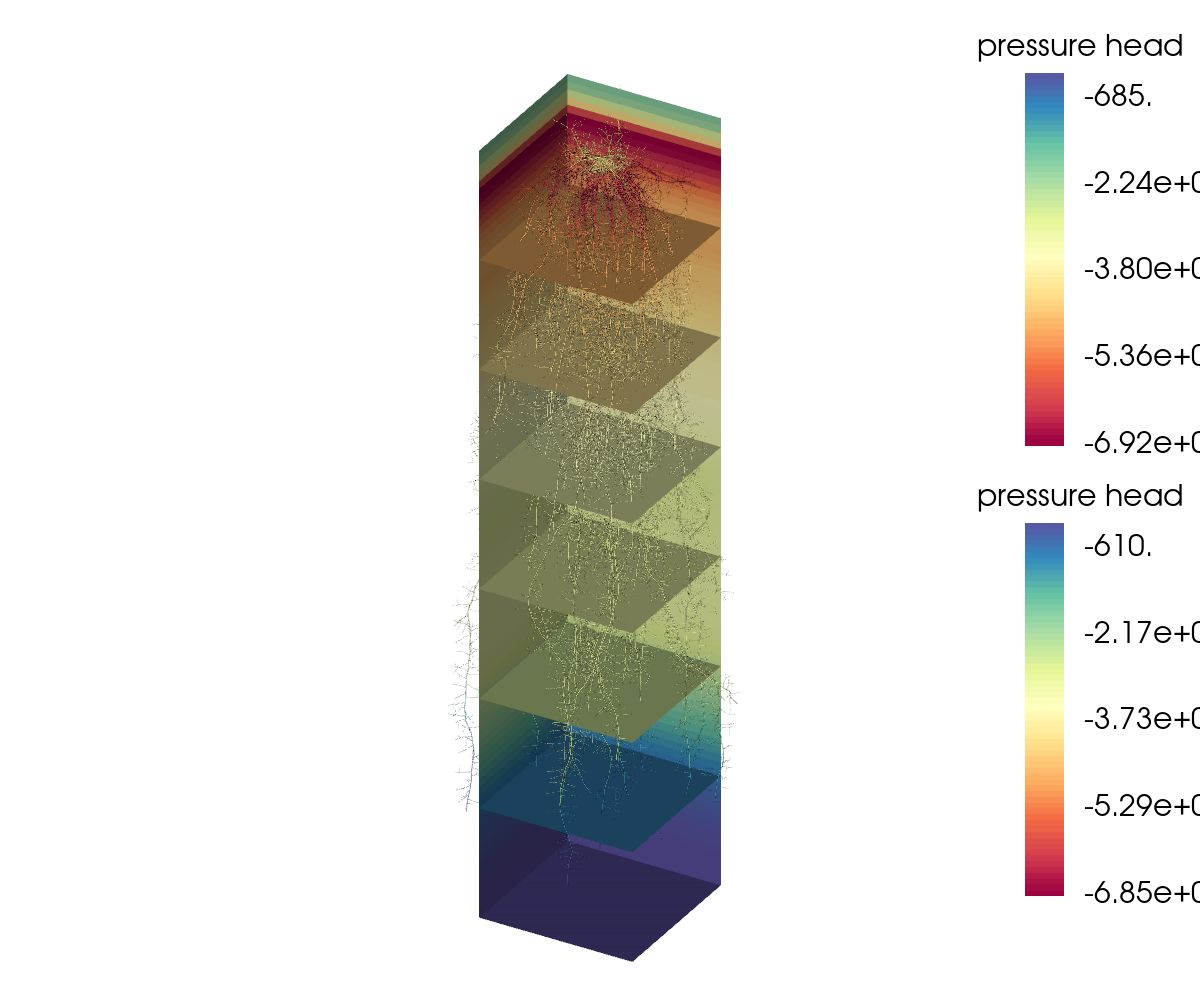

In [12]:

vp.plot_roots_and_soil(hm.ms.mappedSegments(), "pressure head", hm.get_hs(h_bs), s, False, min_b, max_b, 
                       cell_number, interactiveImage = False)  # VTK vizualisation


# Group Excercises

In [ ]:
""" Parameters """  
verbose = False
depth = 100

min_b = np.array([-38., -8., -depth])
max_b = np.array([38., 8., 0.])
cell_number = [1, 1,depth]  # [cm3]


path = sourcedir + "modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI_modified"  #"Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010, Zeamays_synMRI.xml  <<<<-------
#trans_ = 
trans = (max_b[0] - min_b[0]) * (max_b[1] - min_b[1]) * trans_  # cm3 / day
wilting_point = -15000  # cm
rs_age = 8 * 7  # 56 days  # root system initial age [day]
# soil_params = []
sp = vg.Parameters(soil_params)  # needed for Perirhizal class
vg.create_mfp_lookup(sp, wilting_point = -15000, n = 1501)  # needed for Perirhizal class
initial = # cm

sim_time = 7  # [day]
dt = 3600. / (24 * 3600)  # [days]  


In [ ]:

""" Initialize macroscopic soil model """
s = RichardsWrapper(RichardsSP())  
s.initialize()
s.createGrid(min_b, max_b, cell_number, periodic = True)  # [cm]
s.setHomogeneousIC(initial, False)  # [cm] False = matrix, True, = total potential
#s.setTopBC()
#s.setBotBC()
s.setVGParameters([soil_params])
s.setParameter("Soil.SourceSlope", "100") 
s.initializeProblem()
s.setCriticalPressure(wilting_point)  

""" Initialize xylem model """
plant = pb.MappedPlant() 
plant.enableExtraNode()
plant.readParameters(path + name + ".xml")

for p in plant.getOrganRandomParameter(pb.seed):
    p.seedPos.z = -5
for p in plant.getOrganRandomParameter(pb.root):
    if (p.subType == 1)|(p.subType == 4):
        #p.theta = 
        #p.tropismS =  
    if (p.subType == 1)|(p.subType == 4)|(p.subType == 5):
        #p.ln =  
        #p.r =  

sdf = pb.SDF_PlantBox(np.inf, np.inf, max_b[2] - min_b[2] - 0.5)  
plant.setGeometry(sdf)  
plant.setRectangularGrid(pb.Vector3d(min_b), pb.Vector3d(max_b), pb.Vector3d(cell_number), False, False)  # needed for Perirhizal class

""" root hydraulic properties """
param = PlantHydraulicParameters()  

#kr0_max = 
#kr1_max = 
kr0 = np.array([[0., kr0_max], [12.5, kr0_max], [20.9, kr0_max/2], [44.6, kr0_max/2], [62.7, kr0_max/10], [100, kr0_max/10]])
kr1 = np.array([[0., kr1_max], [10, kr1_max], [15, kr1_max/10], [25, kr1_max/10]])
param.set_kr_age_dependent(kr0[:, 0], kr0[:, 1], subType = [1, 4, 5])  
param.set_kr_age_dependent(kr1[:, 0], kr1[:, 1], subType = [2, 3])

kx0 = np.array([[0, 2.7e-2], [18.3, 2.7e-2], [21, 3.3e-1], [47, 3.3e-1], [61, 4.2], [100, 4.2]])
kx1 = np.array([[0, 1.e-4], [9, 2.e-4], [13, 6.e-4], [20, 1.73e-3], [25, 1.73e-3]])
param.set_kx_age_dependent(kx0[:, 0], kx0[:, 1], subType = [1, 4, 5])
param.set_kx_age_dependent(kx1[:, 0], kx1[:, 1], subType = [2, 3]) 
 
hm = HydraulicModel_Doussan(plant, param)
hm.wilting_point = wilting_point  

""" Coupling (map indices) """
picker = lambda x, y, z: s.pick([0, 0, z]) 
plant.setSoilGrid(picker)
plant.initialize(True)
plant.simulate(rs_age, True)
hm.test() 

peri = Perirhizal(plant)
h_bs = s.getSolutionHead()
h_sr = np.ones(h_bs.shape) * wilting_point

In [ ]:
""" Numerical solution """
start_time = timeit.default_timer()
t = 0.
x_, y_ = [], []
N = round(sim_time / dt)
area = (plant.maxBound.x - plant.minBound.x) * (plant.maxBound.y - plant.minBound.y)  # [cm2]

for i in range(0, N): 

    h_bs = s.getSolutionHead()
    h_bs = np.array(plant.matric2total(h_bs))

    start_time_ao = timeit.default_timer()

    hm.update(rs_age + sim_time)

    # Alpha: root system averaged stress factor
    # krs, _ = hm.get_krs(rs_age + sim_time)  # [cm2/day] (could be precomputed for static case)
    krs = hm.krs
    krs = krs / area
    if verbose:
        print("krs", krs)

    k_srs = hm.get_soil_rootsystem_conductance(rs_age + sim_time, h_bs, wilting_point, sp)
    h_bs_diff = h_bs - np.ones(h_bs.shape) * wilting_point
    alpha = np.multiply(k_srs, h_bs_diff) / (-krs * wilting_point)  # [1]

    # Omega: root system averaged stress factor
    # suf_ = hm.get_suf(rs_age + sim_time)
    suf_ = hm.suf
    suf = peri.aggregate(suf_[0,:])
    alphaSUF = np.multiply(alpha, suf)
    omega = np.nansum(alphaSUF)  # note that nan are treated as 0
    if verbose:
        print("omega", omega)

    # Omega_c: critical stress factor
    tp = trans * sinusoidal(t) / area  # potential tranpiration [cm3 day-1] -> [cm day-1]
    # print("tp", tp)
    omega_c = tp / (-wilting_point * krs)
    if verbose:
        print("max uptake", (-wilting_point * krs), tp)
        print("omega_c", omega_c)
        print("omega / omega_c", omega / omega_c)

    # Sink, stressed
    q_s = alphaSUF * tp / omega_c

    # Sink, unstressed
    denumerator = np.multiply(h_bs_diff, np.nansum(np.divide(alphaSUF, h_bs_diff)))
    if verbose:
        print("denumerator", np.nansum(denumerator), np.nanmin(denumerator), np.nanmax(denumerator))
        print("- term: ", np.nansum(np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp))
    q_us = alphaSUF * tp / omega_c - np.divide(alphaSUF, denumerator) * (omega / omega_c - 1) * tp

    if verbose:
        print("pot", tp, "q_us", np.nansum(q_us), "q_s", np.nansum(q_s))

    if omega < omega_c:
        print("stressed")
        q = q_s
    else:
        print("unstressed")
        q = q_us

    start_time_soil = timeit.default_timer()

    fluxes = make_source(q, area)
    s.setSource(fluxes)
    s.solve(dt) 

    final_time = timeit.default_timer()

    x_.append(t)
    y_.append(-np.nansum(q) * area) 

    n = round(float(i) / float(N) * 100.)  
    print("[" + ''.join(["*"]) * n + ''.join([" "]) * (100 - n) + "], potential {:g}, actual {:g}; [{:g}, {:g}] cm soil at {:g} days"
            .format(tp * area, np.nansum(q) * area, np.min(h_bs), np.max(h_bs), s.simTime))

    print("wall times:", (start_time_ao - start_time_soil) / (start_time_ao - final_time), (start_time_soil - final_time) / (start_time_ao - final_time))

    t += dt  # [day]

print ("Coupled benchmark solved in ", timeit.default_timer() - start_time, " s")  # |\label{l7xa:timing}|


In [ ]:
""" Transpiration over time """
fig, ax1 = plt.subplots()
ax1.plot(x_, trans * sinusoidal(x_), 'k')  # potential transpiration
ax1.plot(x_, -np.array(y_), 'g')  # actual transpiration
ax2 = ax1.twinx()
ax2.plot(x_, np.cumsum(-np.array(y_) * dt), 'c--')  # cumulative transpiratio
ax1.set_xlabel("Time [d]")
ax1.set_ylabel("Transpiration $[mL d^{-1}]$ per plant")
ax1.legend(['Potential', 'Actual', 'Cumulative'], loc = 'upper left')
plt.show()

In [ ]:

vp.plot_roots_and_soil(hm.ms.mappedSegments(), "pressure head", hm.get_hs(h_bs), s, False, min_b, max_b, 
                       cell_number, interactiveImage = False)  # VTK vizualisation
